In [3]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np

from pathlib import Path

# Load Data

In [5]:
data_folder = "../data/external/"

tourney_results = pd.read_csv(data_folder + "MNCAATourneyDetailedResults.csv")
seeds = pd.read_csv(data_folder + 'MNCAATourneySeeds.csv')
regular_results = pd.read_csv(data_folder + 'MRegularSeasonDetailedResults.csv')

teams = pd.read_csv(f"../data/external/MTeams.csv")

In [6]:
tourney_results.shape

(1115, 34)

In [7]:
seeds.shape

(2286, 3)

In [8]:
regular_results.shape

(92832, 34)

In [9]:
pd.options.display.max_columns=35
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [10]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [11]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [12]:
all(regular_results.columns == tourney_results.columns)

True

# Data Prep

The CSV files comprise of game details for winning and losing teams. Need to duplicate so have stats for both teams, then can calculate statistics for each team based on past performance. 

Steps:
1. Create copies of data: losing team and winning team dataframes
2. Change "WLoc" to "location", and switch H/A in losing team dataframe
3. Winning team DF: replace "W" with "T1_" and "L" with "T2_". Vice versa with losing team column
4. Concat dataframes, sort by index, then reset index

In [13]:
# copies:
winners = regular_results.copy()
losers = regular_results.copy()

# reset WLoc column:
winners.columns.values[6] = 'location'
losers.columns.values[6] = 'location'

# switch H/A in losers df:
losers.loc[losers['location'] == 'H', 'location'] = 'A'
losers.loc[losers['location'] == 'A', 'location'] = 'H'

# replace W and L with appropriate prefix:
winners.columns = winners.columns.str.replace("W", "T1_").str.replace("L", "T2_")
losers.columns = losers.columns.str.replace("W", "T2_").str.replace("L", "T1_")

# combine:
regular_data = pd.concat([winners, losers]).sort_index().reset_index(drop=True)

In [14]:
def prepare_data(df):
    """Prepares the regular and tournament datasets.
    
    Parameter
    ---------
    df : pandas DataFrame using the tournament/regular season CSV files
    """
    # copies:
    winners = df.copy()
    losers = df.copy()

    # reset WLoc column:
    winners.columns.values[6] = 'location'
    losers.columns.values[6] = 'location'

    # switch H/A in losers df:
    losers.loc[losers['location'] == 'H', 'location'] = 'A'
    losers.loc[losers['location'] == 'A', 'location'] = 'H'

    # replace W and L with appropriate prefix:
    winners.columns = winners.columns.str.replace("W", "T1_").str.replace("L", "T2_")
    losers.columns = losers.columns.str.replace("W", "T2_").str.replace("L", "T1_")

    # combine:
    output = pd.concat([winners, losers]).sort_index().reset_index(drop=True)
    
    # change location preprocessing:
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    # calc point diff:
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [15]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)
tourney_data_og = tourney_data.copy()

In [16]:
regular_data.shape

(185664, 35)

In [17]:
tourney_data.shape

(2230, 35)

In [18]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1328,62,1104,68,0,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22,-6
2,2003,10,1393,63,1272,70,0,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18,-7
3,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
4,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12


# Feature Engineering

Steps:
1. Calculate season statistics for each team (T1_ and T2_) and for opponents of T1_ and T2_
2. Calculate 2-weeks prior to tourney stats for each team and opponents
3. Calculte regular season meeting results (if available) (?)
4. GLM team quality?


## Season Stats

In [19]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [20]:
# team and opponent regular season stats:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
T1_season_stats = season_statistics.copy()
T2_season_stats = season_statistics.copy()

T1_season_stats.columns = [''.join(col).strip() for col in T1_season_stats.columns.values]
T1_season_stats.columns = T1_season_stats.columns.str.replace("T2_", "T1_opponent_")

T2_season_stats.columns = [''.join(col).strip() for col in T2_season_stats.columns.values]
T2_season_stats.columns = ["T2_" + s.replace("T1_", "").replace("T2_", "opponent_") for s in T2_season_stats.columns]

T1_season_stats.columns.values[0] = 'Season'
T2_season_stats.columns.values[0] = 'Season'

In [21]:
tourney_data = tourney_data_og[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,134,1411,84,1421,92
2,2003,136,1436,51,1112,80
3,2003,136,1112,80,1436,51
4,2003,136,1113,84,1272,71


In [22]:
tourney_data.shape

(2230, 6)

In [23]:
# combine:
tourney_data = pd.merge(tourney_data_og, T1_season_stats, on=['Season', 'T1_TeamID'], how='left')
tourney_data = pd.merge(tourney_data, T2_season_stats, on=['Season', 'T2_TeamID'], how='left')
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,...,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,...,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,134,1411,84,1421,92,0,1,29,67,12,31,14,31,17,28,16,...,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379
2,2003,136,1436,51,1112,80,0,0,20,64,4,16,7,7,8,26,12,...,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286
3,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,...,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
4,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,...,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655


In [24]:
tourney_data.shape

(2230, 73)

## 14-Day Win Ratio

In [25]:
# Calc prior 2 weeks win %
last14_days_T1 = regular_data.loc[regular_data['DayNum']>118].reset_index(drop=True)
last14_days_T1['win'] = np.where(last14_days_T1['PointDiff'] > 0, 1, 0)
last14_days_T1 = last14_days_T1.groupby(['Season', 'T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14_days_T2 = regular_data.loc[regular_data['DayNum']>118].reset_index(drop=True)
last14_days_T2['win'] = np.where(last14_days_T2['PointDiff'] < 0, 1, 0)
last14_days_T2 = last14_days_T2.groupby(['Season', 'T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [26]:
# add to tourney data:
tourney_data = pd.merge(tourney_data, last14_days_T1, on=['Season', 'T1_TeamID'], how='left')
tourney_data = pd.merge(tourney_data, last14_days_T2, on=['Season', 'T2_TeamID'], how='left')
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,...,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,...,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333
1,2003,134,1411,84,1421,92,0,1,29,67,12,31,14,31,17,28,16,...,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,0.833333,1.000000
2,2003,136,1436,51,1112,80,0,0,20,64,4,16,7,7,8,26,12,...,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,1.000000,0.666667
3,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,...,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000
4,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,...,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000


In [27]:
tourney_data.shape

(2230, 75)

# Add Seed Difference

In [28]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[['Season', 'seed', 'TeamID']].copy()
seeds_T2 = seeds[['Season', 'seed', 'TeamID']].copy()

seeds_T1.columns = ['Season', 'T1_seed', 'T1_TeamID']
seeds_T2.columns = ['Season', 'T2_seed', 'T2_TeamID']


tourney_data = pd.merge(tourney_data, seeds_T1, on=['Season', 'T1_TeamID'], how='left')
tourney_data = pd.merge(tourney_data, seeds_T2, on=['Season', 'T2_TeamID'], how='left')

# seed diff:
tourney_data['SeedDiff'] = tourney_data['T1_seed'] - tourney_data['T2_seed']

In [29]:
tourney_data.shape

(2230, 78)

# KenPom Variables

In [32]:
# import kp data scraped from kenpom.com
kenpom_df = pd.read_csv("../data/raw/pomerlow.csv")
kenpom_df.head()

,Rk,Team,Conf,W-L,AdjEM,AdjO,Strength of Schedule_AdjD,NCSOS_AdjT,Season
0,1,Kentucky 1,SEC,32-4,29.18,116.5,5,87.4,2003
1,2,Kansas 2,B12,30-8,28.62,115.0,12,86.4,2003
2,3,Pittsburgh 2,BE,28-5,28.61,114.8,14,86.2,2003
3,4,Arizona 1,P10,28-4,26.80,115.6,10,88.8,2003
4,5,Illinois 4,B10,25-7,24.47,113.2,22,88.7,2003


In [33]:
kenpom_df = pd.read_csv("../data/raw/pomerlow.csv")

to_replace = {
    "\s?[0-9]":"",
    "(\s{1}st\.?$)": " state",
    "-": " ",
    "\(": "",
    "\)": "",
    "ut rio grande valley": "texas rio grande valley",
    "texas a&m corpus chris": "a&m corpus chris",
    "southwest missouri state":"sw missouri state",
    "texas a&m corpus christi": "a&m corpus christi",
    "cal st. bakersfield": "cal state bakersfield",
    "st. francis pa":"st francis pa",
    "troy state": "troy",
}
kenpom_df = kenpom_df_og.copy()
kenpom_df['TeamName'] = kenpom_df_og['Team'].str.lower()
kenpom_df['TeamName'] = kenpom_df['TeamName'].replace(regex=to_replace)

spellings = pd.read_csv(data_folder + "MTeamSpellings.csv", encoding = "ISO-8859-1")
spellings['TeamName'] = spellings['TeamNameSpelling']
teams = pd.read_csv(f"../data/external/MTeams.csv", encoding = "ISO-8859-1")

all_team_names = teams[['TeamName', 'TeamID']].append(spellings[['TeamName', 'TeamID']])
all_team_names['TeamName'] = all_team_names['TeamName'].str.lower()
all_team_names['TeamName'] = all_team_names['TeamName'].str.replace("-", " ")
all_team_names = all_team_names.drop_duplicates()
kenpom_df = pd.merge(kenpom_df, all_team_names, on='TeamName', how='left')
print(f"{kenpom_df['TeamID'].isna().sum()} missing ID's")

kp_cols = ['Season', 'TeamID',
    'Rk', 'AdjEM', 'AdjO',
    'Strength of Schedule_AdjD', 
    'NCSOS_AdjT',  
]

kp_data = kenpom_df[kp_cols]
T1_kp = kp_data.copy(deep=True)
T2_kp = kp_data.copy(deep=True).reset_index(drop=True)

T1_kp.columns = ["T1_" + c for c in T1_kp.columns]
T1_kp.columns.values[0] = "Season"

T2_kp.columns = ["T2_" + c for c in T2_kp.columns]
T2_kp.columns.values[0] = 'Season'


tourney_data = tourney_data.merge(T1_kp, on=['Season', 'T1_TeamID'], how='left')
tourney_data = tourney_data.merge(T2_kp, on=['Season', 'T2_TeamID'], how='left')

5 missing ID's


In [34]:
tourney_data.shape

(2230, 88)

In [36]:
pd.options.display.max_columns = 100
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,SeedDiff,T1_Rk,T1_AdjEM,T1_AdjO,T1_Strength of Schedule_AdjD,T1_NCSOS_AdjT,T2_Rk,T2_AdjEM,T2_AdjO,T2_Strength of Schedule_AdjD,T2_NCSOS_AdjT
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0,283,-12.35,101.2,187,113.5,260,-10.45,98.3,238,108.7
1,2003,134,1411,84,1421,92,0,1,29,67,12,31,14,31,17,28,16,15,5,0,22,32,69,11,29,17,26,14,30,17,12,5,3,22,-8,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,0.833333,1.000000,16,16,0,260,-10.45,98.3,238,108.7,283,-12.35,101.2,187,113.5
2,2003,136,1436,51,1112,80,0,0,20,64,4,16,7,7,8,26,12,17,10,3,15,31,66,7,23,11,14,11,36,22,16,10,7,8,-29,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,1.000000,0.666667,16,1,15,150,+1.57,101.1,191,99.5,4,+26.80,115.6,10,88.8
3,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15,4,+26.80,115.6,10,88.8,150,+1.57,101.1,191,99.5
4,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3,30,+16.49,113.9,18,97.4,29,+16.72,110.9,35,94.1


In [37]:
tourney_data['T1_Score'] - tourney_data['T2_Score']

0        8
1       -8
2      -29
3       29
4       13
        ..
2225    10
2226    -1
2227     1
2228     8
2229    -8
Length: 2230, dtype: int64

# Model Building

In [210]:
# define log-loss scoring
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [318]:
features = [
       'location', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d',
       'T2_win_ratio_14d', 'T1_seed', 'T2_seed', 'SeedDiff', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_Strength of Schedule_AdjD', 'T1_NCSOS_AdjT',
       'T2_Rk', 'T2_AdjEM', 'T2_AdjO', 'T2_Strength of Schedule_AdjD',
       'T2_NCSOS_AdjT'
]

features = [
    'T1_win_ratio_14d',
       'T2_win_ratio_14d', 'T1_seed', 'T2_seed', 'SeedDiff', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_Strength of Schedule_AdjD', 'T1_NCSOS_AdjT',
       'T2_Rk', 'T2_AdjEM', 'T2_AdjO', 'T2_Strength of Schedule_AdjD',
       'T2_NCSOS_AdjT'
]

df = tourney_data.dropna(how='any')

X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)

# split training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

# group_kfold = GroupKFold(n_splits=len(set(groups)))

In [299]:
def print_score(m):
    res = {
        "train log loss":log_loss(y_train, m.predict(X_train)), 
        "val log loss" : log_loss(y_val, m.predict(X_val)),
        "training r^2" : m.score(X_train, y_train), 
        "validation r^2" : m.score(X_val, y_val)
        }
    if hasattr(m, 'oob_score_'): 
        res['oob score'] = m.oob_score_
    for label, val in res.items(): 
        print(label + ": ", val)

## Random Forest
Just to get warmed up again.

In [319]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)

%time model.fit(X_train, y_train)

print_score(model)

Wall time: 251 ms
train log loss:  0.13550852465115243
val log loss:  0.6370378945516281
training r^2:  0.9043085487642445
validation r^2:  0.26330025252525247


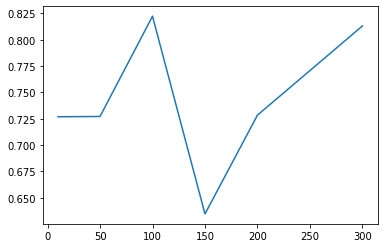

In [320]:
n_trees = [10, 50, 100, 150, 200, 300]
val_log_loss = []
for n in n_trees:
    model = RandomForestRegressor(
        n_estimators=100, n_jobs=-1, oob_score=True, 
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(n_trees, val_log_loss)

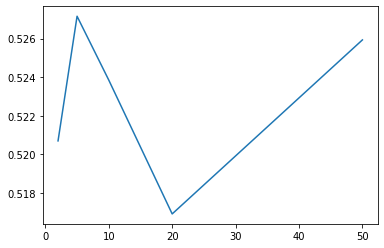

In [302]:
params = dict(
    n_estimators=100,
    min_samples_leaf=20,
)

min_samples_leaf = [2, 5, 10, 20, 50]
val_log_loss = []
for msl in min_samples_leaf:
    model = RandomForestRegressor(
        n_estimators=100, n_jobs=-1, oob_score=True, 
        min_samples_leaf=msl
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(min_samples_leaf, val_log_loss)

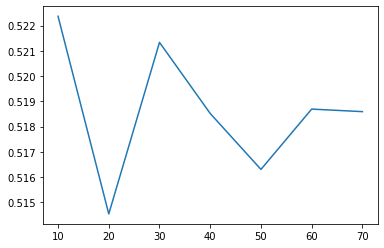

In [303]:
params = dict(
    n_estimators=100,
    min_samples_leaf=20,
)

max_leaf_nodes = [10, 20, 30, 40, 50, 60, 70]

val_log_loss = []
for m in max_leaf_nodes:
    model = RandomForestRegressor(
     n_jobs=-1, oob_score=True, max_leaf_nodes=m, **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(max_leaf_nodes, val_log_loss)


In [304]:
params = dict(
    n_estimators=100,
    min_samples_leaf=20,
    max_leaf_nodes=20,
    oob_score=True,
    n_jobs=-1
)
model = RandomForestRegressor(
     **params
    )
model.fit(X_train, y_train)
print_score(model)

train log loss:  0.4004131071373427
val log loss:  0.5173029197684927
training r^2:  0.49979555078943194
validation r^2:  0.3096774247594707
oob score:  0.32715899552348693


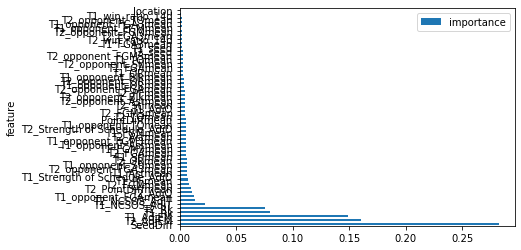

In [307]:
fi = pd.DataFrame(zip(features, model.feature_importances_),
                 columns=['feature', 'importance'])
new_features = fi.sort_values(by='importance', ascending=False)[:20]

fi.sort_values(by='importance', ascending=False).plot(kind='barh', x='feature')

## CV Pipe

In [450]:
from sklearn.model_selection import LeaveOneGroupOut
def cv_score(m, X_test_, y_test_, print_=True):
    res = log_loss(y_test_, m.predict(X_test_))
    if print_: print(f"Val log loss: {res}")
    return res

def leave_one_out_CV(estimater, params, folds, df, features):
    X = df[features].copy()
    y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
    groups = df['Season'].values - 2003

    # split training and testing:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)


    cv_res = {}
    group_kfold = LeaveOneGroupOut()
    groups_ = groups[X_train.index]

    for i in range(folds):
        print(f"Fold repeater {i}")
        cv_res[i] = []
        for train_index, test_index in group_kfold.split(X_train.values, y_train, groups_):
            X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_, y_test_ = y_train[train_index], y_train[test_index]

            m = estimater(**params, random_state=i)
            m.fit(X_train_, y_train_)
            cv_res[i].append(cv_score(m, X_test_, y_test_, print_=False))
        print(f"Fold Log Loss: {np.mean(cv_res[i])}")

    cv_results = [np.mean(vals) for i, vals in cv_res.items()]
    print("CV Fold Results", cv_results)
    print("Mean CV Log Loss: ", np.mean(cv_results))

In [451]:
df = tourney_data.dropna(how='any').reset_index(drop=True)

leave_one_out_CV(estimater=RandomForestRegressor, params=params, 
                 folds=3, df=df, features=features)

Fold repeater 0
Fold Log Loss: 0.49547801952973575
Fold repeater 1
Fold Log Loss: 0.4958890165869647
Fold repeater 2
Fold Log Loss: 0.4956158261281895
CV Fold Results [0.49547801952973575, 0.4958890165869647, 0.4956158261281895]
Mean CV Log Loss:  0.49566095408162997
